In [3]:
#pip install numpy pandas matplotlib 

In [4]:
import numpy as np

def mouvement_brownien(r, q, sigma, Z, S0, t):
    S_t = S0 * np.exp((r - q - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * Z)
    return S_t

def decision(tableau, strike, barrier, coupon, S0):
    for i in range(len(tableau)):
        if tableau[i] >= strike:
            # SCÉNARIO A : Rappel anticipé
            return S0 + ((i + 1) * coupon)
    
    # Pas de rappel anticipé
    prix_final = tableau[-1]
    
    if prix_final >= barrier:
        # SCÉNARIO B : Pas de rappel mais protection du capital
        return S0
    else:
        # SCÉNARIO C : Perte en capital 
        return prix_final

def montecarlo(n_simulations, S0, r, q, sigma, strike, barrier, coupon, annees):
    payoffs = []
    for _ in range(n_simulations):
        trajectoire = []
        current_S = S0
        # On simule année après année pour créer un "chemin"
        for t in range(1, annees + 1):
            Z = np.random.normal(0, 1)
            # On simule le prix à l'année t à partir du prix à l'année t-1
            current_S = mouvement_brownien(r, q, sigma, Z, current_S, 1) # dt = 1 an
            trajectoire.append(current_S)
        
        # On calcule le gain pour cette trajectoire
        resultat = decision(trajectoire, strike, barrier, coupon, S0)
        payoffs.append(resultat)
        
    # On fait la moyenne et on actualise
    return np.exp(-r * annees) * np.mean(payoffs)

# --- Paramètres ---
n_simulations = 50000
S0 = 100
r = 0.05
q = 0.02
sigma = 0.2
strike = 100
barrier = 60 
coupon = 10
annees = 5

prix_produit = montecarlo(n_simulations, S0, r, q, sigma, strike, barrier, coupon, annees)
print(f"Le prix du produit structuré est : {prix_produit:.2f}") # Affiche le prix avec 2 décimales

Le prix du produit structuré est : 84.69


Text(0, 0.5, 'Prix du sous-jacent')

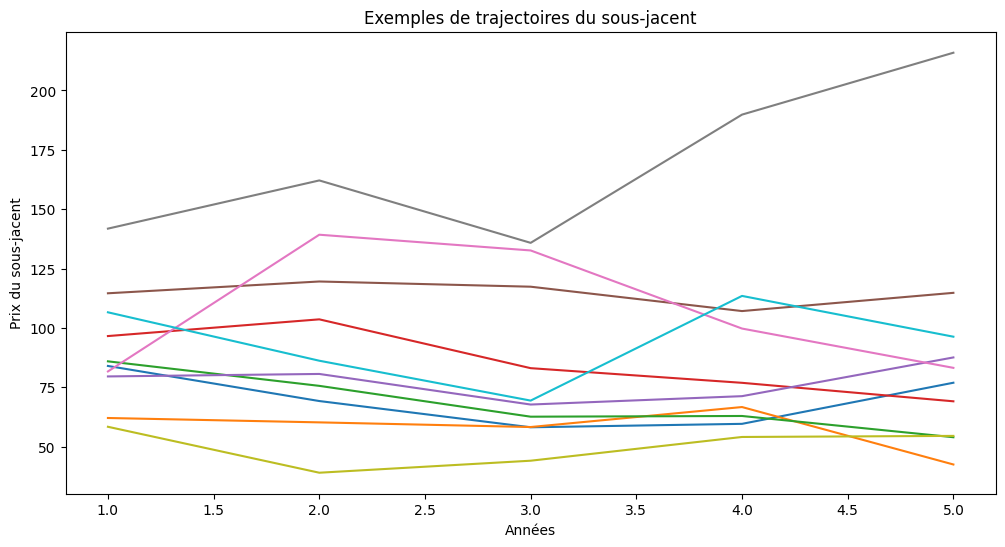

In [5]:
import matplotlib.pyplot as plt
# Visualisation de quelques trajectoires
n_trajectoires = 10
plt.figure(figsize=(12, 6))
for _ in range(n_trajectoires):
    trajectoire = []
    current_S = S0
    for t in range(1, annees + 1):
        Z = np.random.normal(0, 1)
        current_S = mouvement_brownien(r, q, sigma, Z, current_S, 1)
        trajectoire.append(current_S)
    plt.plot(range(1, annees + 1), trajectoire)
plt.title("Exemples de trajectoires du sous-jacent")
plt.xlabel("Années")
plt.ylabel("Prix du sous-jacent")

In [6]:
def montecarlo_loss(n_simulations, S0, r, q, sigma, strike, barrier, coupon, annees):
    payoffs = []
    loss = 0
    for _ in range(n_simulations):
        trajectoire = []
        current_S = S0
        # On simule année après année pour créer un "chemin"
        for t in range(1, annees + 1):
            Z = np.random.normal(0, 1)
            # On simule le prix à l'année t à partir du prix à l'année t-1
            current_S = mouvement_brownien(r, q, sigma, Z, current_S, 1) # dt = 1 an
            trajectoire.append(current_S)
        
        # On calcule le gain pour cette trajectoire
        resultat = decision(trajectoire, strike, barrier, coupon, S0)
        if resultat < S0 :
            loss +=1
        payoffs.append(resultat)
        
    # On fait la moyenne et on actualise
    return [np.exp(-r * annees) * np.mean(payoffs),loss]

n_simulations = 50000
S0 = 100
r = 0.05
q = 0.02
sigma = 0.2
strike = 100
barrier = 60 
coupon = 10
annees = 5

prix_produit, loss = montecarlo_loss(n_simulations, S0, r, q, sigma, strike, barrier, coupon, annees)
print(f"Le prix du produit structuré est : {prix_produit:.2f}")
print(f"Sur {n_simulations} on a perdu {loss} fois du capital")


Le prix du produit structuré est : 84.84
Sur 50000 on a perdu 3714 fois du capital


In [7]:

def variation_sigma(sigma_list):
    resultats_complets = []
    for s in sigma_list:
        res = montecarlo_loss(n_simulations, S0, r, q, s, strike, barrier, coupon, annees)
        resultats_complets.append([s, res[0], res[1]])
    return resultats_complets


sigma_list = [0.15, 0.30, 0.45, 0.60, 0.75, 0.90, 1]
n_simulations = 10000 # Réduction du nombre de simulations pour accélérer le calcul

stats = variation_sigma(sigma_list)


print(f"{'Sigma':<10} | {'Prix Produit':<15} | {'Pertes':<10} | {'% Prob. Perte'}") #En-tête du tableau (<10 la largeur du champ)
print("-" * 60)

for ligne in stats:
    s_val, p_val, l_val = ligne
    prob_perte = (l_val / n_simulations) * 100
    print(f"{s_val:<10.2f} | {p_val:<15.2f} | {l_val:<10} | {prob_perte:.2f}%")

Sigma      | Prix Produit    | Pertes     | % Prob. Perte
------------------------------------------------------------
0.15       | 87.09           | 279        | 2.79%
0.30       | 79.01           | 1768       | 17.68%
0.45       | 70.79           | 2808       | 28.08%
0.60       | 63.00           | 3644       | 36.44%
0.75       | 56.69           | 4196       | 41.96%
0.90       | 50.34           | 4830       | 48.30%
1.00       | 46.39           | 5196       | 51.96%


Text(0, 0.5, 'Prix du produit')

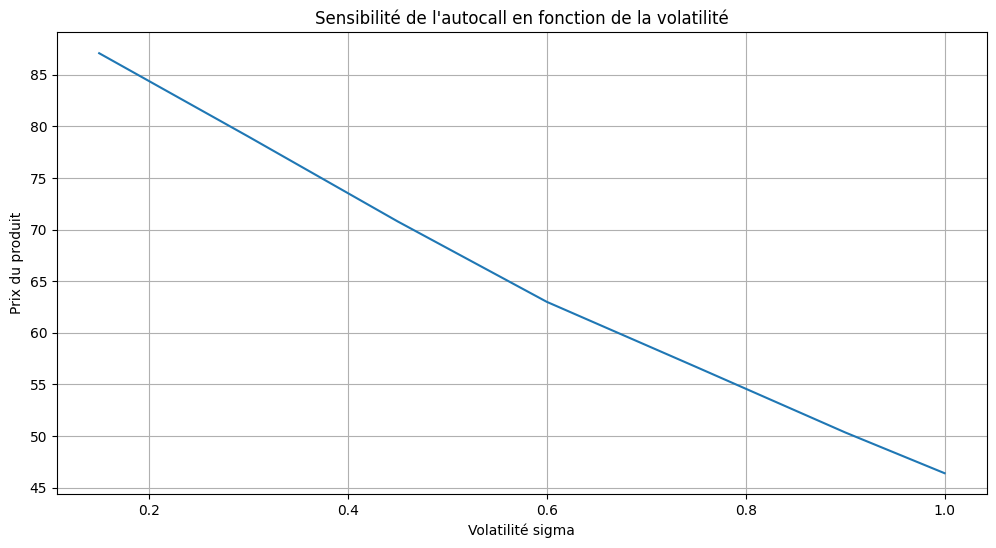

In [8]:
import matplotlib.pyplot as plt
sigmas = [value[0] for value in stats]
prix = [value[1] for value in stats]

plt.figure(figsize=(12, 6))
plt.plot(sigmas,prix)
plt.grid(True)
plt.title("Sensibilité de l'autocall en fonction de la volatilité")
plt.xlabel("Volatilité sigma")  
plt.ylabel("Prix du produit")

In [ ]:
def variation_q(q_list):
    resultats_complets = []
    for q_val in q_list:
        res = montecarlo_loss(n_simulations, S0, r, q_val, sigma, strike, barrier, coupon, annees)
        resultats_complets.append([q_val, res[0], res[1]])
    return resultats_complets

q_list = [0, 0.05, 0.10, 0.15,]
n_simulations = 10000 # Réduction du nombre de simulations pour accélérer le calcul

stats = variation_q(q_list)
    
print(f"{'Q':<10} | {'Prix Produit':<15} | {'Pertes':<10} | {'% Prob. Perte'}") #En-tête du tableau (<10 la largeur du champ)
print("-" * 60)

for ligne in stats:
    q_val, p_val, l_val = ligne
    prob_perte = (l_val / n_simulations) * 100
    print(f"{q_val:<10.2f} | {p_val:<15.2f} | {l_val:<10} | {prob_perte:.2f}%")

Q          | Prix Produit    | Pertes     | % Prob. Perte
------------------------------------------------------------
0.00       | 86.60           | 474        | 4.74%
0.05       | 81.22           | 1327       | 13.27%
0.10       | 72.32           | 2799       | 27.99%
0.15       | 60.38           | 4753       | 47.53%


Text(0, 0.5, 'Prix du produit')

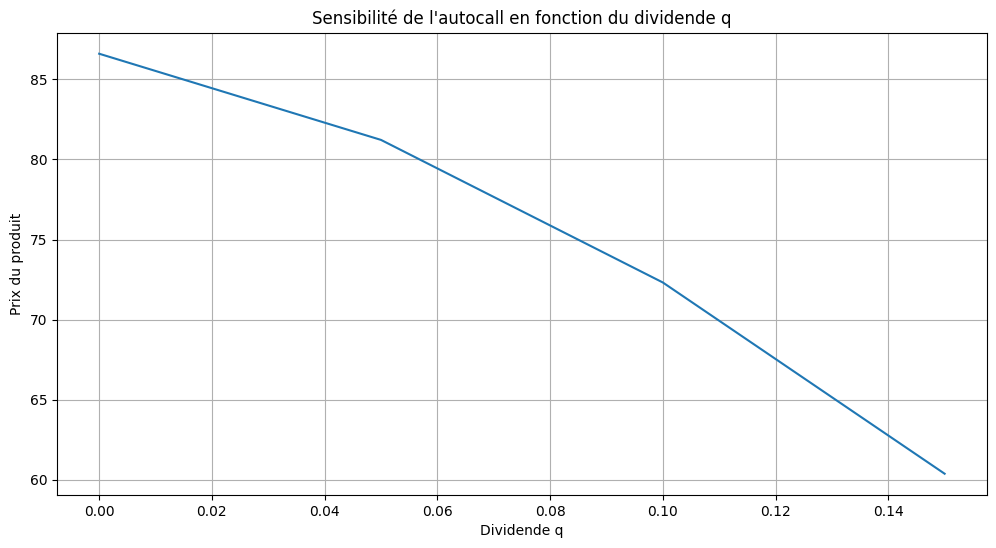

In [10]:
import matplotlib.pyplot as plt
qs = [value[0] for value in stats]
prix = [value[1] for value in stats]

plt.figure(figsize=(12, 6))
plt.plot(qs,prix)
plt.grid(True)
plt.title("Sensibilité de l'autocall en fonction du dividende q")
plt.xlabel("Dividende q")  
plt.ylabel("Prix du produit")